In [1]:
%load_ext autoreload
%autoreload 2
import sys
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from data_generate_RPF_count import *
from dataset_prepare import *
from translation_transformer import *
from RotaryEmbedding import *
from model_trainer import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

## Data prepare

### load file

In [2]:
tx_arrays_file = '/home/user/data3/rbase/translation_pred/models/lib/transcript_arrays.pkl'
RPF_count_file = '/home/user/data3/rbase/translation_pred/models/test/SRR15513158.read_count.pkl'
tx_seq_file = '/home/user/data3/rbase/translation_pred/models/lib/tx_seq.v48.pkl'
with open(tx_arrays_file, 'rb') as f:
    tx_arrays = pickle.load(f)
with open(RPF_count_file, 'rb') as f:
    RPF_count = pickle.load(f)
with open(tx_seq_file, 'rb') as f:
    tx_seq = pickle.load(f)

### load datasets

In [ ]:
# split dataset
chrom_train = ["chr" + str(i) for i in range(1,17)] + ["X"]
chrom_valid = ["chr" + str(i) for i in range(17,21)]
chrom_test = ["chr" + str(i) for i in range(21,23)] + ["Y"]
# create dataset of target transcripts
batch_size = 12
loader = BatchDatasetLoader(tx_seq, tx_arrays, chrom_train, batch_size, min_length=200, max_length=3000)
# data embedding
train_dataset = loader.compute_batches(RPF_count)
val_dataset = loader.compute_batches(RPF_count)
# test_dataset = pbd(RPF_count, tx_seq, tx_arrays, chrom_test, batch_size, min_length=100)

### Data Preparation ###


Batch Processing:  13%|█▎        | 375/2801 [00:11<06:42,  6.03it/s] 

### view dataset

In [4]:
latest_idx = len(train_dataset) - 1
train_x = torch.from_numpy(
    np.concatenate(
        (train_dataset[3]["seq_embeddings"], train_dataset[3]["count_embeddings"]), axis=2)
).to(torch.float32).cuda()
mask = torch.from_numpy(train_dataset[3]["pad_mask"]).cuda()
print(train_x.shape)
print(mask.unsqueeze(1).unsqueeze(2).shape)

torch.Size([12, 1765, 14])
torch.Size([12, 1, 1, 1765])


## Test Positonal Encoding (PE)

### Sinusoidal PE

In [5]:
d_model = train_x.shape[-1]
## parallel in 2 gpu
pe = nn.DataParallel(PositionalEncoding(d_model,  max_seq_length=20000), device_ids=[0,1]).cuda()
train_x_pos_em = pe(train_x)
print("Test positional_encoding. PE value:\n", train_x_pos_em)
del pe
torch.cuda.empty_cache()

Test positional_encoding. PE value:
 tensor([[[ 0.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  1.5403e+00,  2.5116e-02,  9.9968e-01,  6.3096e-04],
         [ 9.0930e-01, -4.1615e-01,  5.0217e-02,  1.9987e+00,  1.2619e-03],
         ...,
         [-8.7327e-01,  1.4872e+00, -7.6240e-01, -6.4710e-01,  5.4314e-01],
         [ 9.3817e-01,  9.9809e-01, -7.7841e-01, -6.2775e-01,  5.4367e-01],
         [ 8.0645e-01,  5.9130e-01, -7.9394e-01,  3.9200e-01,  5.4420e-01]],

        [[ 0.0000e+00,  2.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  1.5403e+00,  2.5116e-02,  9.9968e-01,  6.3096e-04],
         [ 9.0930e-01,  5.8385e-01,  5.0217e-02,  9.9874e-01,  1.2619e-03],
         ...,
         [-8.7327e-01,  4.8724e-01,  2.3760e-01, -6.4710e-01,  5.4314e-01],
         [ 9.3817e-01,  9.9809e-01, -7.7841e-01, -6.2775e-01,  5.4367e-01],
         [ 1.8065e+00,  5.9130e-01, -7.9394e-01, -6.0800e-01,  5.4420e-01]],

        [[ 1.0000e+

### Rotary PE

In [171]:
test_x = torch.from_numpy(train_dataset[0]["masked_embedding"]).to(torch.float32).cuda()
print(test_x.shape)
d_model = test_x.shape[2]
seq_len = test_x.shape[1]
RoPE = LlamaRotaryEmbeddingExt(d_model).cuda()
cos, sin = RoPE.cos_sin_cached(seq_len)
test_x_ro = RoPE(test_x.unsqueeze(1))
print(test_x_ro.shape)

torch.Size([12, 1688, 14])
torch.Size([12, 1, 1688, 14])


<Axes: >

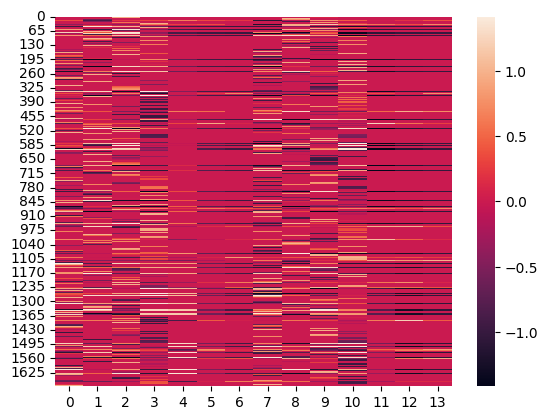

In [172]:
sns.heatmap(test_x_ro[0].squeeze(0).cpu())

<Axes: >

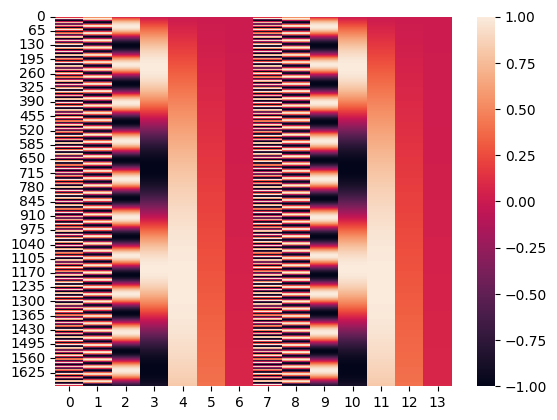

In [174]:
sns.heatmap(sin.squeeze([0,1]).cpu())

<Axes: >

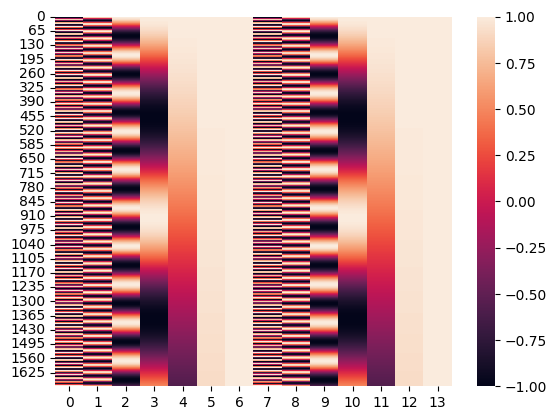

In [168]:
sns.heatmap(cos.squeeze([0,1]).cpu())

## Test Multi-HeadedAttention

In [18]:
bs, seq_len, d_model = train_x.shape
heads=1
multi_headed_attention = nn.DataParallel(MultiHeadedAttention(d_model, heads), device_ids=[0,1]).cuda()
model_output = multi_headed_attention(train_x, mask)
print(f"Test multi_head_attention. Input shape:{(bs, seq_len, d_model)} Output shape: {model_output.shape}")
print(model_output)
del multi_headed_attention
torch.cuda.empty_cache()

Test multi_head_attention. Input shape:(12, 1765, 14) Output shape: torch.Size([12, 1765, 14])
tensor([[[-7.0120e-02, -1.3909e-01,  2.4331e-02,  ...,  9.1265e-02,
          -4.6516e-02, -2.7591e-01],
         [-6.9385e-02, -1.3957e-01,  2.5595e-02,  ...,  9.1447e-02,
          -4.5032e-02, -2.7638e-01],
         [-6.9843e-02, -1.3915e-01,  2.5082e-02,  ...,  9.1335e-02,
          -4.5627e-02, -2.7614e-01],
         ...,
         [-6.9407e-02, -1.3789e-01,  2.5057e-02,  ...,  9.0888e-02,
          -4.5509e-02, -2.7592e-01],
         [-6.8431e-02, -1.3802e-01,  2.6138e-02,  ...,  9.0902e-02,
          -4.4189e-02, -2.7628e-01],
         [-6.8461e-02, -1.3804e-01,  2.6132e-02,  ...,  9.0914e-02,
          -4.4200e-02, -2.7628e-01]],

        [[-1.0279e-01, -1.4976e-01,  6.9192e-03,  ...,  9.7420e-02,
          -7.0310e-02, -2.7168e-01],
         [-1.0472e-01, -1.5007e-01,  6.5849e-03,  ...,  9.7783e-02,
          -7.0874e-02, -2.7158e-01],
         [-1.0462e-01, -1.5023e-01,  5.9103e-03, 

## Test Flash Multi-Headed Attention

In [19]:
bs, seq_len, d_model = train_x.shape
heads=1
flash_multi_headed_attention = nn.DataParallel(FlashMultiHeadedAttention(d_model, heads), device_ids=[0,1]).cuda()
model_output = flash_multi_headed_attention(train_x, mask)
print(f"Test multi_head_attention. Input shape:{(bs, seq_len, d_model)} Output shape: {model_output.shape}")
print(model_output)

Test multi_head_attention. Input shape:(12, 1765, 14) Output shape: torch.Size([12, 1765, 14])
tensor([[[ 0.2295, -0.2902,  0.1481,  ...,  0.1214, -0.1621,  0.2169],
         [ 0.2292, -0.2906,  0.1479,  ...,  0.1209, -0.1620,  0.2166],
         [ 0.2280, -0.2893,  0.1475,  ...,  0.1208, -0.1627,  0.2174],
         ...,
         [ 0.2285, -0.2910,  0.1471,  ...,  0.1203, -0.1622,  0.2160],
         [ 0.2282, -0.2909,  0.1465,  ...,  0.1203, -0.1617,  0.2157],
         [ 0.2282, -0.2909,  0.1465,  ...,  0.1203, -0.1617,  0.2157]],

        [[ 0.2127, -0.2949,  0.1326,  ...,  0.1060, -0.1672,  0.2125],
         [ 0.2122, -0.2945,  0.1312,  ...,  0.1060, -0.1672,  0.2129],
         [ 0.2131, -0.2950,  0.1320,  ...,  0.1065, -0.1666,  0.2125],
         ...,
         [ 0.2127, -0.2957,  0.1309,  ...,  0.1055, -0.1673,  0.2130],
         [ 0.2118, -0.2951,  0.1306,  ...,  0.1053, -0.1672,  0.2125],
         [ 0.2130, -0.2959,  0.1307,  ...,  0.1057, -0.1675,  0.2133]],

        [[ 0.2132, -0

## Test Encoder

In [22]:
bs, seq_len, d_model = train_x.shape
heads=1
p_prob=0.1
number_of_layers=5
dff = 1024

In [25]:
encoder_layer = EncoderLayer(d_model, dff, heads, p_prob, True)
encoder = nn.DataParallel(Encoder(encoder_layer, number_of_layers), device_ids=[0,1]).cuda()
pred_representations_batch = encoder(train_x, mask)
print(f"Test Encode. Input shape:{(bs, seq_len, d_model)} Output shape: {pred_representations_batch.shape}")
print(pred_representations_batch)
del encoder
torch.cuda.empty_cache()

Test Encode. Input shape:(12, 1765, 14) Output shape: torch.Size([12, 1765, 14])
tensor([[[ 1.3403, -1.1815, -1.7278,  ..., -0.9166,  0.2227, -0.2854],
         [ 0.7343, -1.4095, -1.2670,  ..., -0.9674,  0.2945, -0.0094],
         [ 0.8399, -1.1883, -1.4556,  ..., -1.0769,  0.0964,  0.0886],
         ...,
         [ 1.1870, -1.3721, -1.5971,  ..., -0.6740, -0.0712, -0.3368],
         [ 1.2461, -1.4847, -0.9633,  ..., -0.9224,  0.5574, -0.3363],
         [ 0.5637, -1.4828, -1.1031,  ..., -0.7438,  0.3912,  0.0270]],

        [[ 0.9993, -0.8298, -1.8089,  ..., -0.4934,  0.2696, -0.3985],
         [ 1.0281, -0.9724, -1.5167,  ..., -1.1059,  0.3324, -0.2711],
         [ 1.2634, -1.2443, -1.7876,  ..., -0.7373,  0.4715, -0.6178],
         ...,
         [ 0.7409, -1.2236, -1.7228,  ..., -0.3285,  0.0114, -0.2346],
         [ 1.1846, -1.1943, -1.6088,  ..., -1.0768,  0.5622,  0.0157],
         [ 0.8878, -1.1023, -1.6752,  ..., -0.3402,  0.1408, -0.5048]],

        [[ 0.8895, -0.8472, -1.8011

## Train Encoder-only Transformer Model

### model prepare

In [ ]:
bs, seq_len, d_input = train_dataset[0]["masked_embedding"].shape
max_seq_len = max(x['length'] for x in train_dataset)
d_model = 32
dff = 2048
heads = 4
number_of_layers = 12
encoder_transformer = nn.DataParallel(
    EncoderOnlyTransformer(d_input, d_model, dff, heads, number_of_layers, max_seq_len, PE="RoPE", flash_attn=True), 
    device_ids=[0,1]
).cuda()

### train model

In [ ]:
# Define the training parameters
lr = 0.00005
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
trainer = Trainer(
    model = encoder_transformer,
    dataset = train_dataset,
    checkpoint_dir = '/home/user/data3/rbase/translation_pred/models/checkpoint/',
    batch_size = bs,
    learning_rate = lr,
    accumulation_steps = 5,
    beta = (beta_1, beta_2),
    epsilon = epsilon
)

In [ ]:
epoch_num = 100
liveloss = PlotLosses()
train_loss = {'epoch': [], 'batch': []}
val_loss = {'epoch': [], 'batch': []}
for epoch in range(epoch_num):
    logs = {}
    train_epoch_loss, train_batch_loss = trainer.train(epoch)
    train_loss['epoch'].append(train_epoch_loss)
    train_loss['batch'].append(train_batch_loss)
    val_epoch_loss, val_batch_loss = trainer.eval(epoch, val_dataset)
    val_loss['epoch'].append(val_epoch_loss)
    val_loss['batch'].append(val_epoch_loss)
    
    # update loss plot
    logs['loss'] = train_epoch_loss
    logs['val_loss'] = val_epoch_loss
    liveloss.update(logs)
    liveloss.draw()

# save loss data
log_dir = '/home/user/data3/rbase/translation_pred/models/log/'
with open(log_dir + "train_loss.pkl", 'wb') as f_t_loss:
    pickle.dump(train_loss, f_t_loss)
with open(log_dir + "val_loss.pkl", 'wb') as f_v_loss:
    pickle.dump(val_loss, f_v_loss)